<a href="https://colab.research.google.com/github/aka-gera/Data_Classification/blob/main/loan_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLASSIFIER**

*This algorithm will identify the optimal classification machine learning model for a given dataset.*

This dataset is provided by: https://www.kaggle.com/datasets/saramah/loan-data

In [128]:
data_dir = f'saramah/loan-data'

# Import Dataset

In [129]:
! pip install kaggle

In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
!pwd
%cd /content

/content/drive/My Drive/ML2023/data-analysis
/content


In [132]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [133]:
! cp /content/drive/MyDrive/Kaggle_API/kaggle.json ~/.kaggle

In [134]:
! chmod 600 ~/.kaggle/kaggle.json

In [135]:
! kaggle datasets download {data_dir}

Dataset URL: https://www.kaggle.com/datasets/saramah/loan-data
License(s): ODbL-1.0
loan-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [136]:
import os
file_names = os.listdir()
zip_file =   [file for file in file_names if file.endswith('.zip')]
zip_file

['obesity-or-cvd-risk-classifyregressorcluster.zip', 'loan-data.zip']

In [137]:
import zipfile

# Open the zip file
with zipfile.ZipFile(zip_file[-1], 'r') as zip_ref:
    zip_ref.extractall()
    unzipped_file_names = zip_ref.namelist()
unzipped_file_names

['loan_data.csv']

# Import the helper classes

In [138]:
!pwd
%cd /content/drive/MyDrive/ML2023/data-analysis

/content
/content/drive/MyDrive/ML2023/data-analysis


In [139]:
!pip install AutoLogging-ML
!pip install xgboost
!pip install catboost

In [140]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from plotly.subplots import make_subplots
from AutoLogging_ML import AutoLogger
import seaborn as sns

from aka_data_analysis.aka_plot import aka_plot, aka_correlation_analysis
from aka_data_analysis.aka_learning import aka_learn,aka_clean,aka_filter

aka_plot = aka_plot()
aka_corr_an = aka_correlation_analysis()
aka_clean = aka_clean()
aka_learn = aka_learn()
aka_filter = aka_filter()
aka_corr_an = aka_correlation_analysis()

In [141]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np
import pandas as pd


# Dataset Information

In [142]:
df = aka_clean.df_get(f'/content/{unzipped_file_names[0]}')

In [143]:
df.head()

credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0               0  
1            0        0               0  
2            0        0               0  
3            0        0               0  
4            1        0               0

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [145]:
fig = aka_plot.Plot_histogram_Features(df,[0,1,12,13] )
if fig is not None:
    fig.show()

In [146]:
df.describe()

credit.policy     int.rate  installment  log.annual.inc          dti  \
count    9578.000000  9578.000000  9578.000000     9578.000000  9578.000000   
mean        0.804970     0.122640   319.089413       10.932117    12.606679   
std         0.396245     0.026847   207.071301        0.614813     6.883970   
min         0.000000     0.060000    15.670000        7.547502     0.000000   
25%         1.000000     0.103900   163.770000       10.558414     7.212500   
50%         1.000000     0.122100   268.950000       10.928884    12.665000   
75%         1.000000     0.140700   432.762500       11.291293    17.950000   
max         1.000000     0.216400   940.140000       14.528354    29.960000   

              fico  days.with.cr.line     revol.bal   revol.util  \
count  9578.000000        9578.000000  9.578000e+03  9578.000000   
mean    710.846314        4560.767197  1.691396e+04    46.799236   
std      37.970537        2496.930377  3.375619e+04    29.014417   
min     612.000000         178.958333  0.000000e+00     0.000000   
25%     682.000000        2820.000000  3.187000e+03    22.600000   
50%     707.000000        4139.958333  8.596000e+03    46.300000   
75%     737.000000        5730.000000  1.824950e+04    70.900000   
max     827.000000       17639.958330  1.207359e+06   119.000000   

       inq.last.6mths  delinq.2yrs      pub.rec  not.fully.paid  
count     9578.000000  9578.000000  9578.000000     9578.000000  
mean         1.577469     0.163708     0.062122        0.160054  
std          2.200245     0.546215     0.262126        0.366676  
min          0.000000     0.000000     0.000000        0.000000  
25%          0.000000     0.000000     0.000000        0.000000  
50%          1.000000     0.000000     0.000000        0.000000  
75%          2.000000     0.000000     0.000000        0.000000  
max         33.000000    13.000000     5.000000        1.000000

# Clean Dataset

## Drop Duplicate data

In [147]:
df.drop_duplicates()

credit.policy             purpose  int.rate  installment  \
0                 1  debt_consolidation    0.1189       829.10   
1                 1         credit_card    0.1071       228.22   
2                 1  debt_consolidation    0.1357       366.86   
3                 1  debt_consolidation    0.1008       162.34   
4                 1         credit_card    0.1426       102.92   
...             ...                 ...       ...          ...   
9573              0           all_other    0.1461       344.76   
9574              0           all_other    0.1253       257.70   
9575              0  debt_consolidation    0.1071        97.81   
9576              0    home_improvement    0.1600       351.58   
9577              0  debt_consolidation    0.1392       853.43   

      log.annual.inc    dti  fico  days.with.cr.line  revol.bal  revol.util  \
0          11.350407  19.48   737        5639.958333      28854        52.1   
1          11.082143  14.29   707        2760.000000      33623        76.7   
2          10.373491  11.63   682        4710.000000       3511        25.6   
3          11.350407   8.10   712        2699.958333      33667        73.2   
4          11.299732  14.97   667        4066.000000       4740        39.5   
...              ...    ...   ...                ...        ...         ...   
9573       12.180755  10.39   672       10474.000000     215372        82.1   
9574       11.141862   0.21   722        4380.000000        184         1.1   
9575       10.596635  13.09   687        3450.041667      10036        82.9   
9576       10.819778  19.18   692        1800.000000          0         3.2   
9577       11.264464  16.28   732        4740.000000      37879        57.0   

      inq.last.6mths  delinq.2yrs  pub.rec  not.fully.paid  
0                  0            0        0               0  
1                  0            0        0               0  
2                  1            0        0               0  
3                  1            0        0               0  
4                  0            1        0               0  
...              ...          ...      ...             ...  
9573               2            0        0               1  
9574               5            0        0               1  
9575               8            0        0               1  
9576               5            0        0               1  
9577               6            0        0               1  

[9578 rows x 14 columns]

## Swap the target and the last feature

In [148]:
df = aka_clean.swap_features(df,-1)
df.head()

Invalid feature indices or feat_a is equal to feat_b.


credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0               0  
1            0        0               0  
2            0        0               0  
3            0        0               0  
4            1        0               0

### Drop feature(s)


In [149]:
feat =  []
df = aka_clean.drop_feature(df,feat)
df.head()

credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0               0  
1            0        0               0  
2            0        0               0  
3            0        0               0  
4            1        0               0

##  Convert categorical variables into numerical representations

In [150]:
mapping,swapMapping = aka_clean.CleaningVar(df)
df = aka_clean.CleaningDF(df,mapping)
df.head()

credit.policy  purpose  int.rate  installment  log.annual.inc    dti  fico  \
0              1        0    0.1189       829.10       11.350407  19.48   737   
1              1        1    0.1071       228.22       11.082143  14.29   707   
2              1        0    0.1357       366.86       10.373491  11.63   682   
3              1        0    0.1008       162.34       11.350407   8.10   712   
4              1        1    0.1426       102.92       11.299732  14.97   667   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  delinq.2yrs  \
0        5639.958333      28854        52.1               0            0   
1        2760.000000      33623        76.7               0            0   
2        4710.000000       3511        25.6               1            0   
3        2699.958333      33667        73.2               1            0   
4        4066.000000       4740        39.5               0            1   

   pub.rec  not.fully.paid  
0        0               0  
1        0               0  
2        0               0  
3        0               0  
4        0               0

## Balance Dataset

In [151]:
aka_plot.plot_pie(df,-1)

In [152]:
df = aka_clean.balance_df(df,'j')
aka_plot.plot_pie(df, -1)

## Correlation Matrix

In [153]:
aka_corr_an.Plot_Correlation_Matrix(df)

In [154]:

confidence_interval_limit =   [-5,5]             # Define the limits m of the confidence interval [-m, m] and eliminate the outliers'''

correlation_percentage_threshold = .8      # Set the limit of the correlation between the feature to be removed

df_filtered,corr_tmp = aka_learn.filter_drop_corr_df(df,confidence_interval_limit,correlation_percentage_threshold)

diff_shape = (df.shape[0]-df_filtered.shape[0],df.shape[1]-df_filtered.shape[1])
diff_shape,df_filtered.shape

((6583, 0), (2995, 14))

## Graph the features that are highly correlated


In [155]:
fig = aka_corr_an.Plot_Correlate_Features(df,list(corr_tmp))
if fig is not None:
    fig.show()

Empty list is provided.


### Visualize the distribution of the filtered dataset

In [156]:
aka_plot.Plot_box_Features(df,df_filtered,corr_tmp=range(df_filtered.shape[1]))

# Search for the most effective ML algorithm to learn the dataset

In [157]:
pre_proc = 'X'                             # Choose between 'XY' to standardize both 'X' and 'Y',
                                              #                'X' to standardize only 'X',
                                              #                'Y' to standardize only 'Y',

X_train, X_test, y_train, y_test = aka_learn.Learning_data(df_filtered,pre_proc)

In [158]:
r,model =AutoLogger.train_and_log_classification(X_train,y_train,X_test,y_test,size='large')
y_pred = model.predict(X_test)

In [159]:
model

LinearDiscriminantAnalysis()

<Axes: xlabel='validation-accuracy', ylabel='model'>

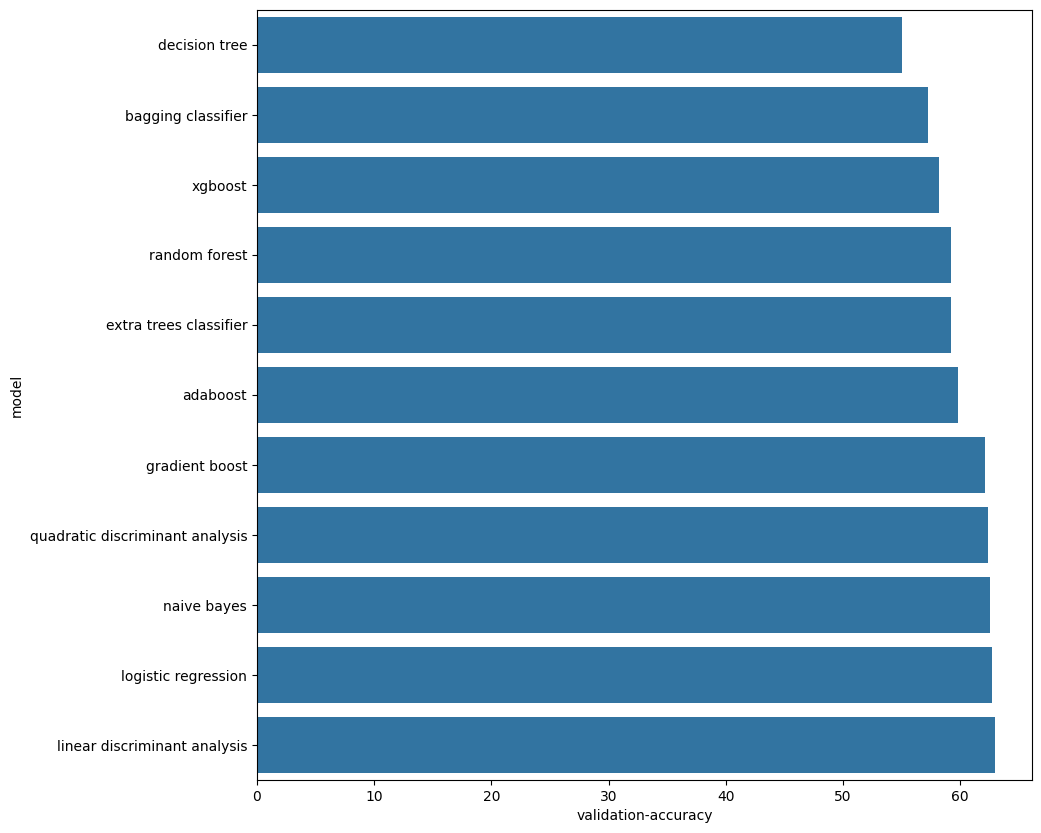

In [160]:
AutoLogger.get_metric_plot_classification(r,'validation','accuracy')

## Confusion Matrix

In [161]:
y_pred_ = aka_clean.swap_map(y_pred,swapMapping)
y_test_ = aka_clean.swap_map(y_test,swapMapping)
Label = [str(un) for un in np.unique(pd.concat([y_pred_, y_test_]))]

In [162]:
Label

['0.0', '1.0']

In [163]:
shw = 1
fig2 =  aka_plot.plot_confusion_matrix(y_test_,y_pred_,Label,shw)
fig2.show()

## Classification Report

In [164]:
shw = 1
fig3 =  aka_plot.plot_classification_report(y_test_,y_pred_,Label,shw)
fig3.show()

## Plot Important Features by Weight

In [167]:
# aka_plot.plot_important_features(model,df_filtered)